# data format
each training sample is going to be:
1 RGB image
16 joints coordinate of 2d

In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms
import pandas as pd


class HandJointsPngAndCsvDataset(Dataset):
    def __init__(self, image_dir, joint_dir, image_size=(512, 512)):
        self.image_dir = image_dir
        self.joint_dir = joint_dir
        self.image_size = image_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_file = image_file.replace(".png", "_joints2d.csv")
        label_path = os.path.join(self.joint_dir, label_file)

        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)

        joint_df = pd.read_csv(label_path)
        coords = joint_df[['u', 'v']].values.astype(np.float32)
        coords /= self.image_size[0]

        return img, torch.tensor(coords)


# load the data

In [14]:
image_dir = '../../../scripts/auto_generator/ply2obj2img'
label_dir = '../../../scripts/auto_generator/ply2obj2img'

dataset = HandJointsPngAndCsvDataset(image_dir, label_dir)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

X = []
y = []

for img, joints in dataset:
    X.append(img.numpy().flatten())
    y.append((joints.numpy().flatten()))

img, joints = dataset[0]
print(img.shape)
print(joints.shape)
print(X.__len__())
print(y.__len__())

torch.Size([3, 512, 512])
torch.Size([16, 2])
1554
1554


# define the model

In [15]:
class MyHandEstimator(nn.Module):
    def __init__(self, num_joints=16):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2),  # output 128*128
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  # output 64*64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # output 32*32
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(256, num_joints * 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x.view(-1, 16, 2)


class JointLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.l2 = nn.MSELoss()

    def forward(self, pred, target):
        return self.l1(pred, target) + 0.5 * self.l2(pred, target)


criterion = JointLoss()


# compute the pixel error

In [16]:



def compute_pixel_error(pred, gt, image_size=512):
    """
    Compute mean pixel error between predicted and ground-truth joint positions.

    Args:
        pred (np.ndarray): shape (16, 2), normalized predicted coordinates (0~1)
        gt (np.ndarray): shape (16, 2), normalized ground truth (0~1)
        image_size (int): width/height in pixels

    Returns:
        float: average Euclidean distance in pixels
    """
    pred_px = pred * image_size
    gt_px = gt * image_size

    pixel_distances = np.linalg.norm(pred_px - gt_px, axis=1)
    return np.mean(pixel_distances), pixel_distances

# define hyperparameters

In [17]:
hyperparameters = [
    {'lr': 1e-4, 'batch_size': 16},
    {'lr': 5e-5, 'batch_size': 16},
    {'lr': 1e-6, 'batch_size': 32},
]

# dataset loading and k-fold cross validation setup

In [18]:
K_outer = 5
outer_cv = KFold(n_splits=K_outer, shuffle=True, random_state=42)

outer_results = []

In [19]:
def evaluate(model, loader):
    model.eval()
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            total += loss.item() * images.size(0)
    return total / len(loader.dataset)

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# models = []
# for outer_fold, (train_and_val_idx, test_idx) in enumerate(outer_cv.split(dataset)):
#     train_and_val_set = Subset(dataset, train_and_val_idx)
#     test_set = Subset(dataset, test_idx)
#
#     # Inner k fold
#     K_inner = 5
#     inner_cv = KFold(n_splits=K_inner, shuffle=True, random_state=42)
#
#     maxi_score = sys.maxsize
#     best_params = None
#
#     for params in hyperparameters:
#         val_loss = []
#         print(f'params: {params}, training started -------------------------------------------------------')
#
#         for inner_train_idx, inner_val_idx in inner_cv.split(train_and_val_idx):
#             inner_train_set = Subset(dataset, np.array(train_and_val_idx)[inner_train_idx])
#             inner_val_set = Subset(dataset, np.array(train_and_val_idx)[inner_val_idx])
#
#             train_loader = torch.utils.data.DataLoader(inner_train_set, batch_size=params['batch_size'], shuffle=True)
#             val_loader = torch.utils.data.DataLoader(inner_val_set, batch_size=params['batch_size'], shuffle=True)
#
#             model = MyHandEstimator(num_joints=16).to(device)
#             optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
#
#             epochs_count = 30
#             for epoch in range(epochs_count):
#                 print(f'epoch: {epoch}')
#                 model.train()
#                 total_loss = 0
#                 for img, joints in train_loader:
#                     img, joints = img.to(device), joints.to(device)
#                     optimizer.zero_grad()
#                     preds = model(img)
#                     loss = criterion(preds, joints)
#                     total_loss += loss.item() * img.size(0)
#                     loss.backward()
#                     optimizer.step()
#                 print(f'total loss: {total_loss / len(train_loader)}')
#
#             # evaluation
#             ev = evaluate(model, val_loader)
#             val_loss.append(ev)
#             print(f'loss: {ev}')
#         avg_val_loss = np.mean(val_loss)
#         print(f'params {params} loss is:{avg_val_loss}')
#
#         if avg_val_loss < maxi_score:
#             best_params = params
#             maxi_score = avg_val_loss
#     print(f"Best Params: {best_params}")
#
#     # retrian using the best hyperparameters
#     train_loader = DataLoader(train_and_val_set, batch_size=best_params['batch_size'], shuffle=True)
#     test_loader = DataLoader(test_set, batch_size=best_params['batch_size'], shuffle=False)
#
#     model = MyHandEstimator(num_joints=16).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
#
#     # Retrain on full train+val
#     for epoch in range(15):
#         model.train()
#         total_loss = 0
#         for imgs, joints in train_loader:
#             imgs, joints = imgs.to(device), joints.to(device)
#             optimizer.zero_grad()
#             preds = model(imgs)
#             loss = criterion(preds, joints)
#             total_loss += loss.item()
#             loss.backward()
#             optimizer.step()
#         print(f'loss: {total_loss / len(train_loader)}')
#
#     # Evaluate on test fold
#     test_loss = evaluate(model, test_loader)
#     print(f"Outer Fold {outer_fold + 1} Test Loss: {test_loss:.4f}")
#     outer_results.append(test_loss)
#
#     models.append(model)

In [21]:
# retrian using the best hyperparameters
indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

model = MyHandEstimator(num_joints=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, joints in train_loader:
        imgs, joints = imgs.to(device), joints.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, joints)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'loss: {total_loss / len(train_loader)}')

# Evaluate on test fold
test_loss = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}")
outer_results.append(test_loss)

loss: 0.641921226794903
loss: 0.6418618315305465
loss: 0.6418473476018661



KeyboardInterrupt



# try to use some built in models

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree_clf = DecisionTreeRegressor(max_depth=7)
tree_clf.fit(X_train, y_train)

scores = cross_val_score(tree_clf, X_test, y_test, cv=kf)

print(scores)

ValueError: Found array with dim 3. DecisionTreeRegressor expected <= 2.

In [12]:
def linear_reg(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)

    print("Model Coefficients:", model.coef_)
    print("Model Intercept:", model.intercept_)

    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error (MAE):", mae)
    return model


linear_model = linear_reg(X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

In [21]:
img_tensor, gt = dataset[0]
input_tensor = img_tensor.unsqueeze(0).to(device)
input_np = np.array([input_tensor.numpy().flatten()])
pred_linear = linear_model.predict(input_np)[0]

gt_pixels = gt.numpy() * 512
pred_pixels = pred_linear * 512

plt.figure(figsize=(5, 5))
plt.imshow(img_tensor.permute(1, 2, 0))  # convert (C, H, W) → (H, W, C)
plt.scatter(gt_pixels[:, 0], gt_pixels[:, 1], c='lime', label='GT')
plt.scatter(pred_pixels[:, 0], pred_pixels[:, 1], c='red', label='Pred')
plt.legend()
plt.title("Predicted vs Ground Truth Joints")
plt.axis('off')
plt.show()

KeyboardInterrupt: 

In [ ]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

model_rbf = SVR(kernel='rbf', C=10.0, epsilon=0.01, gamma=0.01)
model_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = model_rbf.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_rbf)
r2 = r2_score(y_test, y_pred_rbf)
mae = mean_absolute_error(y_test, y_pred_rbf)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print('Mean Absolute Error (MAE):', mae)

In [ ]:
pred_svm = model_rbf.predict(input_np)[0]

gt_pixels = gt.numpy() * 512
pred_pixels = pred_svm * 512

plt.figure(figsize=(5, 5))
plt.imshow(img_tensor.permute(1, 2, 0))  # convert (C, H, W) → (H, W, C)
plt.scatter(gt_pixels[:, 0], gt_pixels[:, 1], c='lime', label='GT')
plt.scatter(pred_pixels[:, 0], pred_pixels[:, 1], c='red', label='Pred')
plt.legend()
plt.title("Predicted vs Ground Truth Joints")
plt.axis('off')
plt.show()

# visualize predicted vs label

In [30]:


model.eval()

with torch.no_grad():
    img_tensor, gt = dataset[0]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    pred = model(input_tensor).cpu()[0].numpy()

gt_pixels = gt.numpy() * 512
pred_pixels = pred * 512

plt.figure(figsize=(5, 5))
plt.imshow(img_tensor.permute(1, 2, 0))  # convert (C, H, W) → (H, W, C)
plt.scatter(gt_pixels[:, 0], gt_pixels[:, 1], c='lime', label='GT')
plt.scatter(pred_pixels[:, 0], pred_pixels[:, 1], c='red', label='Pred')
plt.legend()
plt.title("Predicted vs Ground Truth Joints")
plt.axis('off')
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'eval'

# save the model

In [108]:
save_path = "checkpoints/hand_joint_model.pth"
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to checkpoints/hand_joint_model.pth


# compare with mediapipe


In [110]:



def predict_with_my_model(image_path, model, image_size=(256, 256), device="cpu"):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)[0].cpu().numpy()  # (16, 2)

    return output * 512, image  # Denormalize and return

In [111]:
import mediapipe as mp
import cv2


def predict_with_mediapipe(image_path):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)
    landmarks = []

    if results.multi_hand_landmarks:
        for lm in results.multi_hand_landmarks[0].landmark[:16]:  # only first 16 joints
            landmarks.append([lm.x * 512, lm.y * 512])

    hands.close()
    return np.array(landmarks), Image.fromarray(image_rgb)

I0000 00:00:1754258470.755958 33818654 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1754258470.805581 39231701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754258470.843608 39231701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


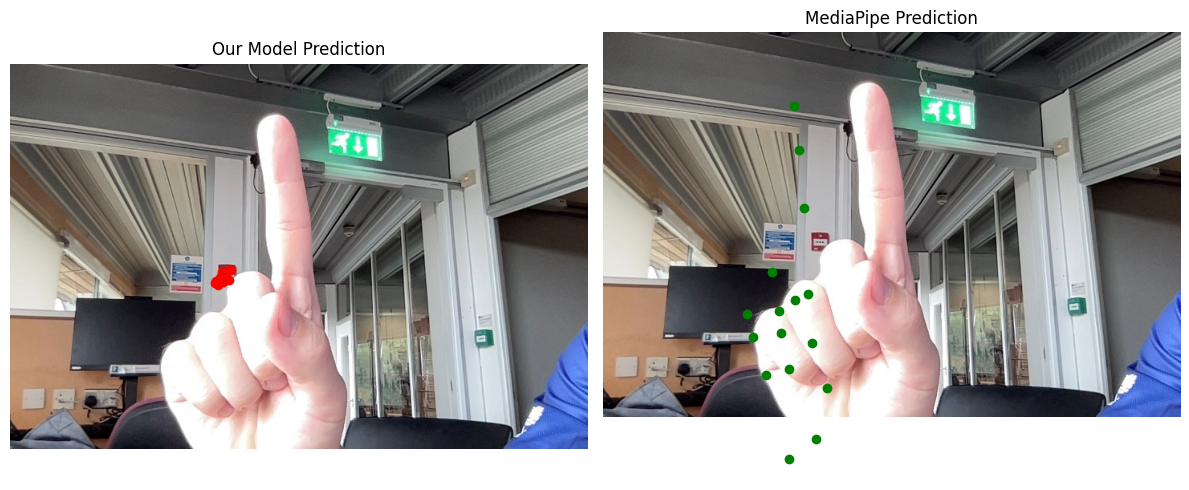

In [112]:
import matplotlib.pyplot as plt


def compare_predictions(img_path, model, device="cpu"):
    pred_ours, img = predict_with_my_model(img_path, model, device=device)
    pred_mp, _ = predict_with_mediapipe(img_path)

    plt.figure(figsize=(12, 6))

    # Ours
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.scatter(pred_ours[:, 0], pred_ours[:, 1], c='red')
    plt.title("Our Model Prediction")
    plt.axis('off')

    # MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    if len(pred_mp) == 16:
        plt.scatter(pred_mp[:, 0], pred_mp[:, 1], c='green')
        plt.title("MediaPipe Prediction")
    else:
        plt.title("MediaPipe Prediction (Not Detected)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


compare_predictions('../../../docs/gesture_design/img.png', model, device)

I0000 00:00:1754258499.005278 33818654 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1754258499.021365 39232107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754258499.035827 39232107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


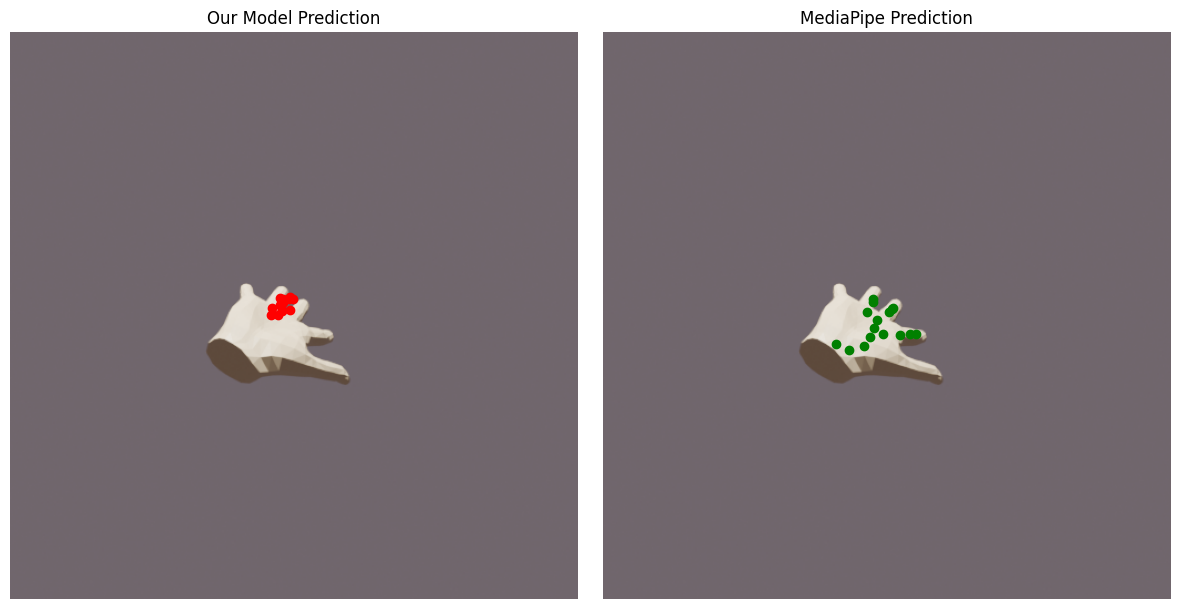

In [113]:
compare_predictions('../../../scripts/auto_generator/ply2obj2img/01_01r.png', model, device)